### Predicting Solana Price with Python and Machine Learning using XGBoost

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('solana_2020-04-09_2024-10-26.csv')
data['Start'] = pd.to_datetime(data['Start'])
data.set_index('Start', inplace=True)

# Feature Engineering: Adding lagged features and rolling statistics
target = 'Close'
lags = [1, 7, 14, 30]
for lag in lags:
    data[f'{target}_lag_{lag}'] = data[target].shift(lag)



In [30]:
# Rolling statistics
data['rolling_mean_7'] = data[target].rolling(window=7).mean()
data['rolling_std_7'] = data[target].rolling(window=7).std()
data['rolling_mean_30'] = data[target].rolling(window=30).mean()
data['rolling_std_30'] = data[target].rolling(window=30).std()

# Drop NaN values created by lagging and rolling windows
data.dropna(inplace=True)


In [32]:
print("Data types before processing:")
print(X.dtypes)

Data types before processing:
End                 object
Open               float64
High               float64
Low                float64
Volume             float64
Market Cap         float64
Close_lag_1        float64
Close_lag_7        float64
Close_lag_14       float64
Close_lag_30       float64
rolling_mean_7     float64
rolling_std_7      float64
rolling_mean_30    float64
rolling_std_30     float64
dtype: object


In [33]:
X = X.copy()  # Create a copy to avoid warnings
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = X[col].astype('category')

# Modify the XGBoost model to handle categorical variables
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True  # Enable categorical feature support
)

In [34]:
# Rest of your hyperparameter grid
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [6, 8, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Hyperparameter tuning with RandomizedSearchCV and TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=Non...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.005, 0.01, 0.05],
                                        'max_depth': [6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [1000, 2000, 3000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [35]:
# Get the best model from the search
best_xgb_model = random_search.best_estimator_

# Make predictions on the entire dataset for visualization purposes
y_pred = best_xgb_model.predict(X)

# Evaluate the model on the entire dataset
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mae = mean_absolute_error(y, y_pred)
print(f'Final RMSE: {final_rmse}, Final MAE: {final_mae}')


Final RMSE: 0.0008485684606789772, Final MAE: 0.0005788799367891521


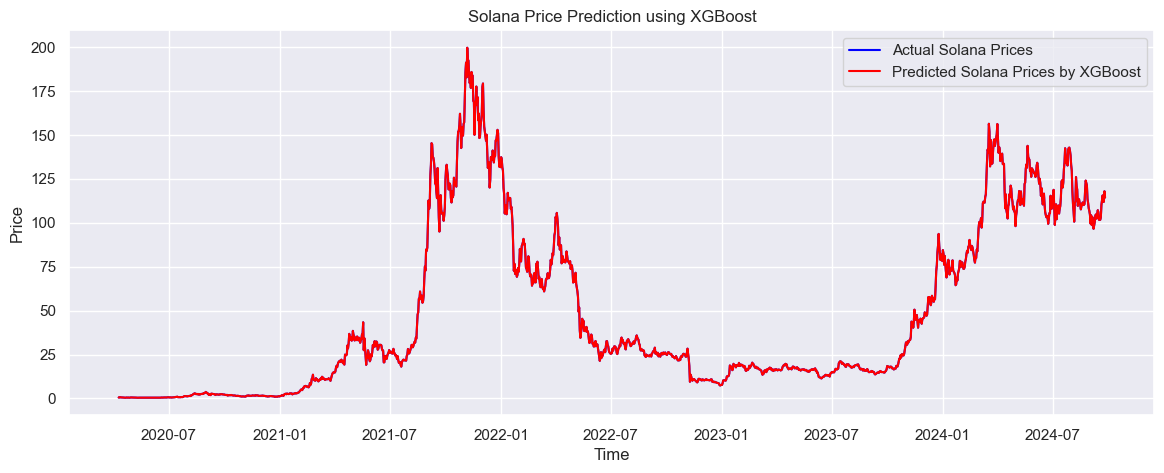

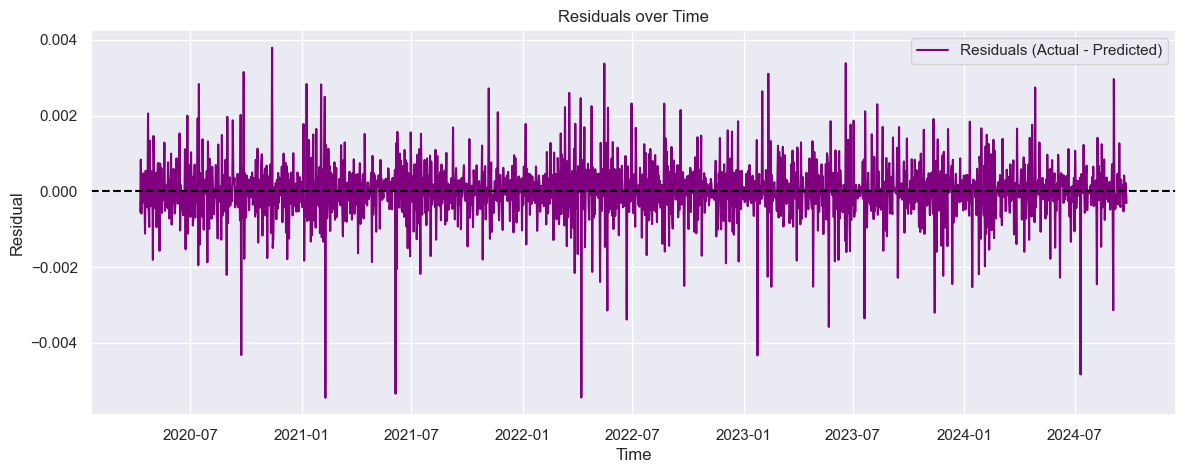

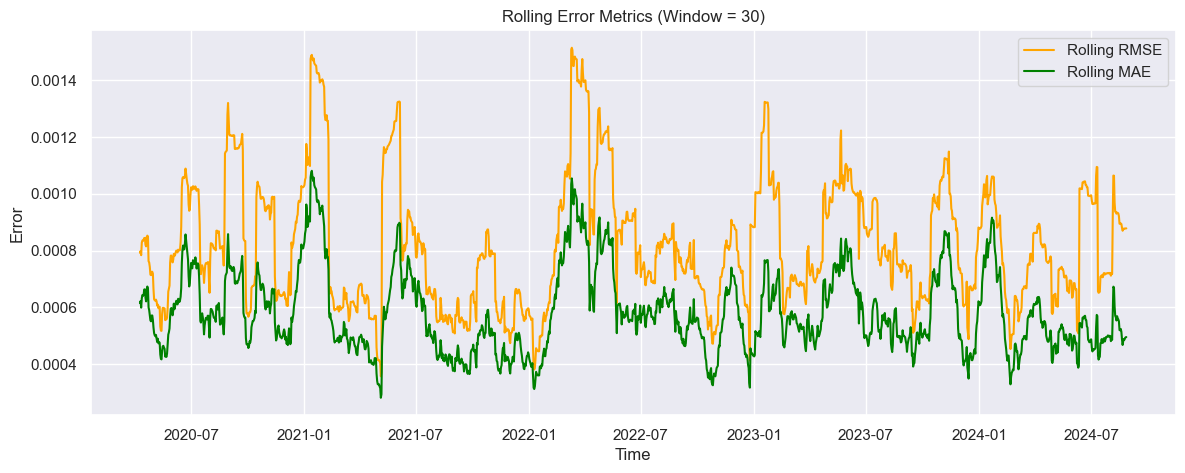

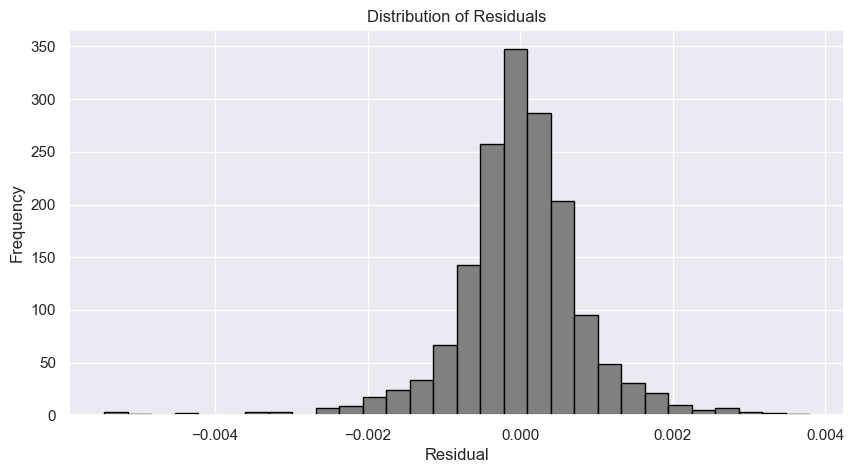

C:\Users\Student\AppData\Local\Temp\ipykernel_89224\1785558640.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')


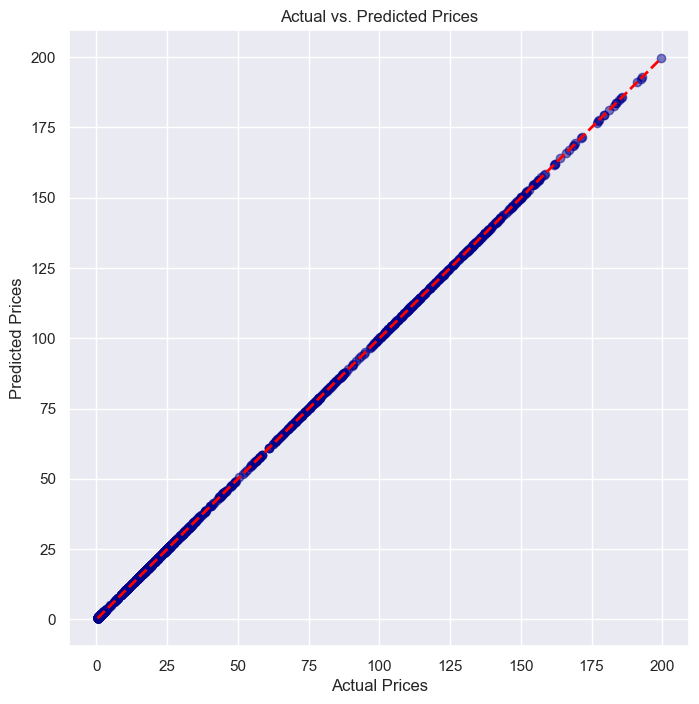

In [36]:

# Visualization Section

# 1. Predictions vs. Actuals Line Plot
plt.figure(figsize=(14, 5))
plt.plot(data.index, y, color='blue', label='Actual Solana Prices')
plt.plot(data.index, y_pred, color='red', label='Predicted Solana Prices by XGBoost')
plt.title('Solana Price Prediction using XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2. Residual Plot
# Calculate residuals
residuals = y - y_pred

plt.figure(figsize=(14, 5))
plt.plot(data.index, residuals, color='purple', label='Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

# 3. Rolling RMSE or MAE Plot
# Define window size (e.g., 30 days)
rolling_window = 30

# Calculate rolling RMSE
rolling_rmse = pd.Series((y - y_pred) ** 2).rolling(window=rolling_window).mean().apply(np.sqrt)
rolling_mae = pd.Series(np.abs(y - y_pred)).rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 5))
plt.plot(data.index, rolling_rmse, color='orange', label='Rolling RMSE')
plt.plot(data.index, rolling_mae, color='green', label='Rolling MAE')
plt.title(f'Rolling Error Metrics (Window = {rolling_window})')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

# 4. Error Distribution (Histogram)
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='grey', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# 5. Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, color='darkblue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()
